In [1]:
import torch
import torch.nn as nn
import torchvision

import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [2]:
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

PyTorch version: 2.3.1+cpu
Torchvision version: 0.18.1+cpu


In [3]:
data_path = Path("data/")
image_path = data_path / "melanoma-cancer"

In [4]:
def walk_trough_dir(dir_path):
    for root, dirs, files in os.walk(dir_path):
        print(f'There are {len(dirs)} directories and {len(files)} files in {root}')

walk_trough_dir(image_path)

There are 2 directories and 0 files in data\melanoma-cancer
There are 2 directories and 0 files in data\melanoma-cancer\test
There are 0 directories and 1000 files in data\melanoma-cancer\test\Benign
There are 0 directories and 1000 files in data\melanoma-cancer\test\Malignant
There are 2 directories and 0 files in data\melanoma-cancer\train
There are 0 directories and 6289 files in data\melanoma-cancer\train\Benign
There are 0 directories and 5590 files in data\melanoma-cancer\train\Malignant


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/melanoma-cancer/train'),
 WindowsPath('data/melanoma-cancer/test'))

Image path: data\melanoma-cancer\train\Malignant\297.jpg
Image class: Malignant
Image size: (224, 224)
Image mode: RGB


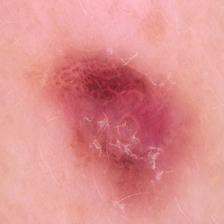

In [6]:
random.seed(42)

image_path_list = list(image_path.glob('**/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f'Image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image size: {img.size}')
print(f'Image mode: {img.mode}')
img

## Transforming data

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
data_transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

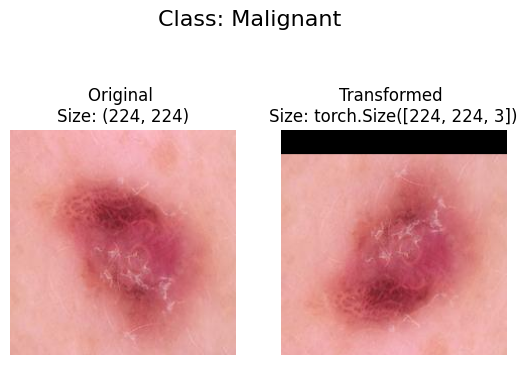

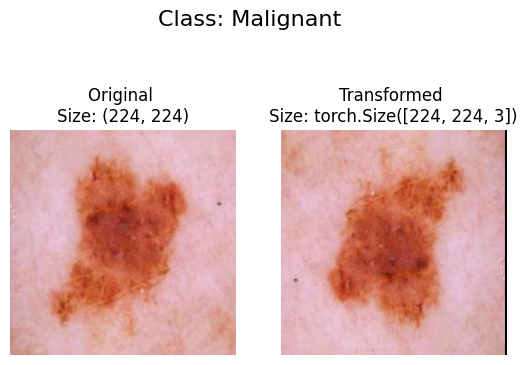

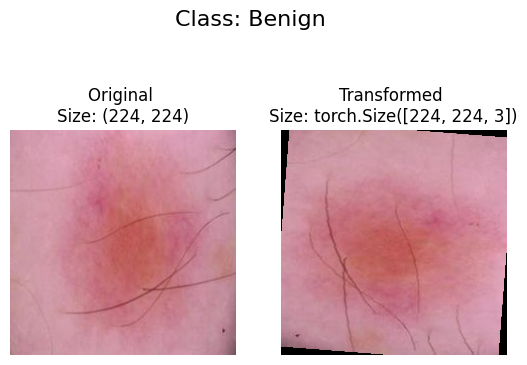

In [9]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [10]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform
)

print(f'Train data: {train_data}\n\n Test data: {test_data}')

Train data: Dataset ImageFolder
    Number of datapoints: 11879
    Root location: data\melanoma-cancer\train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

 Test data: Dataset ImageFolder
    Number of datapoints: 2000
    Root location: data\melanoma-cancer\test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


In [11]:
class_names = train_data.classes
class_names

['Benign', 'Malignant']

In [12]:
class_dict = train_data.class_to_idx
class_dict

{'Benign': 0, 'Malignant': 1}

In [13]:
len(train_data), len(test_data)

(11879, 2000)

Image shape: torch.Size([3, 224, 224])
Label: 0
Class: Benign


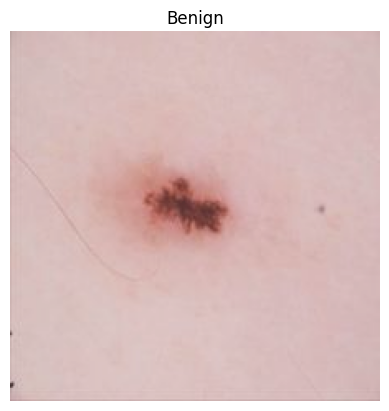

In [14]:
img, label = train_data[0]

print(f'Image shape: {img.shape}')
print(f'Label: {label}')
print(f'Class: {class_names[label]}')

plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off')
plt.show()

### Turn loaded images into DataLoader's

In [15]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count()
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x24c755d3770>,
 <torch.utils.data.dataloader.DataLoader at 0x24c75771130>)

In [16]:
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),

            nn.ReLU(),

            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),

            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*56*56, out_features=512),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x
    
model = TinyVGG()
model

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=512, bias=True)
  )
)

In [17]:
import torchinfo
torchinfo.summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 512]                 --
├─Sequential: 1-1                        [32, 32, 112, 112]        --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─ReLU: 2-2                         [32, 32, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 32, 224, 224]        9,248
│    └─ReLU: 2-4                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 32, 112, 112]        --
├─Sequential: 1-2                        [32, 64, 56, 56]          --
│    └─Conv2d: 2-6                       [32, 64, 112, 112]        18,496
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 64, 112, 112]        36,928
│    └─ReLU: 2-9                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-10                   [32, 64, 56, 56]          --
├─S

## Create train & test

In [18]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          num_epochs: int = 5):
    
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

        # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        tqdm.write(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return results

## Train & evaluate model

In [21]:
torch.manual_seed(42)

NUM_EPOCHS = 5

model = TinyVGG()

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
from timeit import default_timer as timer

start_time = timer()

model_results = train(model, train_dataloader, test_dataloader, loss_fn, optimizer, num_epochs=NUM_EPOCHS)

end_time = timer()

print(f'Training time: {end_time - start_time:.2f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]